In [ ]:
# 62103390
# 遠藤愛期

# 検証内容
##################################################
##################################################
# 4行12列のマスを準備する。
# 左下のマスをスタート地点として、右下のマスをゴール地点とする。
# ただし、一番下の行はスタート地点とゴール地点をのぞいて、崖である。
# このような状況下において、スタート地点を出発して、マスを辿りながらゴールを目指すエージェントの行動を考える。
# ゴールに辿り着くと100点が加算されるが、1マス進むたびに-1が加算される。
# さらに、崖に移動すると、-100点が加算され、スタート地点に強制的に戻される。
# マスの外にでるような行動は無効であるが、-1の罰則は課される。
# この時のエージェントの最適行動をSarsaおよびQ-学習で求める。
##################################################
##################################################

# 検証結果
##################################################
##################################################
# 移動経路について
# SARSA：安全策と取ったルートを選択する（崖を避けるように移動する）
# Q-学習：最短の経路を選択する（崖に沿うように移動する）
##################################################
# 得られる報酬について
# SARSA：最高収益は理論上の最高値より低い（安全策を取っているため）
# Q-学習：学習時の収益は低いが、最適は方策を獲得する（リスクを顧みない行動をしているため）
##################################################
##################################################

# パラメータ変更時の反応
##################################################
##################################################
# EPSILON=0の時、SARSAとQ=学習の結果は同じになる
# SARSAの場合、EPSILONの値を大きくすればするほど、より安全な経路を選択する
##################################################
##################################################

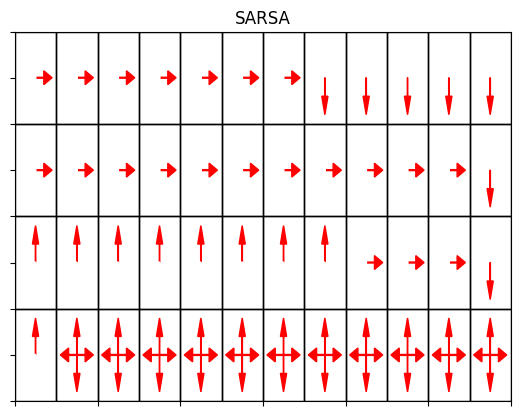

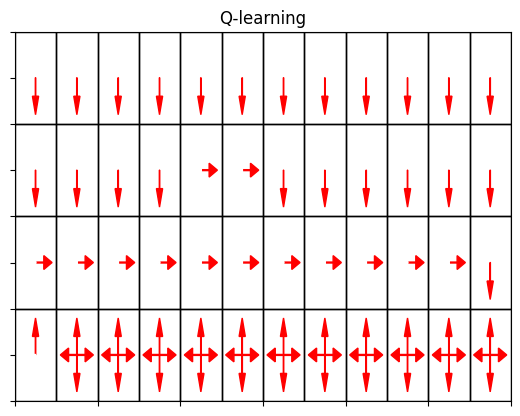

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import criff

ALPHA = 0.01
ALPHA_INI = 0.1 #decay用の初期値
ALPHA_MIN = 0.01 #decay用の最終値
GAMMA = 1.
EPSILON = 0.4
EPS_INI = 0.1 #decay用の初期値
EPS_MIN = 0.0 #decay用の最終値
num_action = 4
num_episode = 1000 # サンプリング数
ex_factor = 5 # decay完了後も学習を続けるパラメータ
num_row = 4
num_col = 12
ACTIONS = ['right', 'up', 'left', 'down']
DECAY_ALPHA = False
DECAY_EPSILON = False

Q_start_pos = np.zeros((len(ACTIONS),int(num_episode * ex_factor)))

result = np.zeros((2, int(num_episode*ex_factor))) # 0 for sarsa, 1 for Q

def select_action(Q, s, eps):
    # e-greedyによる行動選択   
    greedy = np.argmax(Q[:,s[0],s[1]])
    is_greedy_index = np.where(Q[:,s[0],s[1]] == greedy)[0]
    if len(is_greedy_index) > 1:
        greedy = np.random.choice(is_greedy_index)
    p = [(1- eps + eps/len(ACTIONS)) if i == greedy \
        else eps/len(ACTIONS) for i in range(len(ACTIONS))]

    return  np.random.choice(np.arange(len(ACTIONS)), p=p)
  
##################################################
#sarsa
##################################################

# Qの初期化
Q = np.zeros((num_action, num_row, num_col))
#for epi in tqdm(range(int(num_episode*ex_factor))):
for epi in range(int(num_episode*ex_factor)):
    # greedy方策を徐々に確定的にしていく
    if DECAY_EPSILON:
        EPSILON = max(EPS_MIN, EPS_INI* (1- epi*1./num_episode))
    if DECAY_ALPHA:
        ALPHA = max(ALPHA_MIN, ALPHA_INI* (1- epi*1./num_episode))
    
    # sの初期化
    done = False
    agent = criff.Agent()
    s = agent.get_pos() # 環境をリセット
    # e-greedyによる行動選択   
    a = select_action(Q, s, EPSILON)
    
    tmp = 0 # 報酬積算用
    count = 0

    criff_count = 0
    # エピソードを終端までプレイ
    while(done==False):

        # 行動aをとり、r, s'を観測
        s_dash, reward, done = agent.move(ACTIONS[a])

        if reward == -100:
            criff_count+=1

        tmp += reward

        # e-greedyによる行動選択   
        a_dash = select_action(Q, s_dash, EPSILON)

        # Qの更新
        Q_dash = Q[a_dash, s_dash[0], s_dash[1]]
        Q[a,s[0],s[1]] += ALPHA*(reward + GAMMA*(Q_dash)\
                                    - Q[a,s[0],s[1]])
        s = s_dash
        a = a_dash

        count += 1

        if count>200:
            done = True

    result[0, epi] = tmp

    Q_start_pos[:,epi] = Q[:,3,0]
    Q_for_sarsa = Q

##################################################
#Q-learning
##################################################

# Qの初期化
Q = np.zeros((num_action, num_row, num_col))
#for epi in tqdm(range(int(num_episode*ex_factor))):
for epi in range(int(num_episode*ex_factor)):
    # greedy方策を徐々に確定的にしていく
    if DECAY_EPSILON:
        EPSILON = max(EPS_MIN, EPS_INI* (1- epi*1./num_episode))
    if DECAY_ALPHA:
        ALPHA = max(ALPHA_MIN, ALPHA_INI* (1- epi*1./num_episode))
    
    # sの初期化
    done = False
    agent = criff.Agent()
    s = agent.get_pos() # 環境をリセット

    # e-greedyによる行動選択   
    a = select_action(Q, s, EPSILON)
    
    tmp = 0 # 報酬積算用
    count = 0

    criff_count = 0
    # エピソードを終端までプレイ
    while(done==False):
        # e-greedyによる行動選択   
        a = select_action(Q, s, EPSILON)
 
        # 行動aをとり、r, s'を観測
        s_dash, reward, done = agent.move(ACTIONS[a])

        if reward == -100:
            criff_count+=1

        tmp += reward

        # Qの最大値をとる行動を選択   
        a_dash = select_action(Q, s_dash, 0)

        # Qの更新
        Q_dash = Q[a_dash, s_dash[0], s_dash[1]]
        Q[a,s[0],s[1]] += ALPHA*(reward + GAMMA*(Q_dash)\
                                    - Q[a,s[0],s[1]])
        s = s_dash

        count += 1

        if count>200:
            done = True

    result[1, epi] = tmp

    Q_start_pos[:,epi] = Q[:,3,0]
    Q_for_q = Q


criff.Q_arrow_plot(Q_for_sarsa)
plt.title('SARSA')
plt.show()
criff.Q_arrow_plot(Q_for_q)
plt.title('Q-learning')
plt.show()
